# Setup

## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from datetime import date, timedelta
import torch
from math import radians, cos, sin, asin, sqrt
import os
import math
from tqdm import tqdm

Mounted at /content/drive


## Read in Raw Datasets

In [2]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/Summer_Invitational_2023_Datathon_Datasets/'
#file_path = "/content/drive/My Drive/Citadel-Datathon-2023/Data/";

# all raw datasets
df_airports = pd.read_csv(file_path + 'airports.csv', engine = 'python', encoding = 'unicode_escape')
df_airlines = pd.read_csv(file_path + 'airlines.csv')
# df_events = pd.read_csv(file_path + 'events_US.csv', engine = 'python', encoding = 'unicode_escape')
# df_fares = pd.read_csv(file_path + 'fares.csv')
df_traffic = pd.read_csv(file_path + 'flight_traffic.csv')
df_stock = pd.read_csv(file_path + 'stock_prices.csv')
df_weather = pd.read_csv(file_path + 'weather.csv')

# Standardize Format of Datasets

## Stock Data

In [3]:
# convert stock dataset's date-time to proper format
df_stock.rename(columns = {'timestamp':'date'}, inplace = True)
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock = df_stock.sort_values(by='date', ascending=True)
df_stock['date'] = df_stock['date'].dt.strftime('%m-%d-%y')
df_stock = df_stock.reset_index(drop=True)
display(df_stock)

,date,AA,UA,B6,OO,AS,NK,WN,DL,HA
0,10-03-16,37.70,53.2500,17.66,27.70,67.09,43.7400,39.740,39.98,49.99
1,10-04-16,37.63,53.7300,17.83,27.89,68.71,43.6400,39.160,40.15,50.63
2,10-05-16,37.87,53.8200,17.86,28.06,68.31,43.1600,39.100,40.32,50.83
3,10-06-16,38.17,53.9800,17.62,28.52,69.09,42.9900,39.170,39.94,50.82
4,10-07-16,37.73,52.8200,17.39,28.50,68.11,42.2400,38.470,38.95,49.50
...,...,...,...,...,...,...,...,...,...,...
375,04-02-18,49.78,66.7700,19.73,52.75,57.75,36.3500,54.340,51.95,36.85
376,04-03-18,51.47,69.1900,20.15,54.80,60.11,37.2200,55.970,53.72,38.75
377,04-04-18,52.04,69.9900,20.48,55.45,61.22,37.7000,56.360,53.86,40.50
378,04-05-18,52.14,70.6900,20.64,56.05,62.11,38.3000,56.860,54.21,41.20


## Weather Data

In [4]:
# convert weather df's datetime to proper format
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['date'] = df_weather['datetime'].dt.strftime('%m-%d-%y')
# columns to keep and average
to_avg = ['temperature', 'wind_direction', 'wind_speed', 'snow_depth', 'cloud_status', 'visibility', 'latitude', 'longitude', 'elevation']
# average temperature and
df_weather = df_weather.groupby(['date','airport_id','airport_name'], as_index=False)[to_avg].mean()

df_weather.interpolate(method='linear', inplace=True)
display(df_weather)

,date,airport_id,airport_name,temperature,wind_direction,wind_speed,snow_depth,cloud_status,visibility,latitude,longitude,elevation
0,01-01-17,ABE,"ALLENTOWN LEHIGH VALLEY INTERNATIONAL AIRPORT,...",6.250,414.75,3.725,NaN,9.0,16093.00,40.64985,-75.44771,118.9
1,01-01-17,ABI,"ABILENE REGIONAL AIRPORT, TX US",9.725,150.00,3.100,NaN,9.0,16093.00,32.41050,-99.68220,545.6
2,01-01-17,ABQ,"ALBUQUERQUE INTERNATIONAL AIRPORT, NM US",4.450,175.00,3.200,NaN,9.0,16093.00,35.04190,-106.61550,1618.5
3,01-01-17,ABR,"ABERDEEN REGIONAL AIRPORT, SD US",-7.500,384.75,3.225,NaN,9.0,16093.00,45.44330,-98.41300,395.3
4,01-01-17,ABY,"ALBANY SW GEORGIA REGIONAL AIRPORT, GA US",12.900,364.75,2.825,NaN,9.0,14483.75,31.53556,-84.19444,57.9
...,...,...,...,...,...,...,...,...,...,...,...,...
88437,12-31-17,VLD,"VALDOSTA REGIONAL AIRPORT, GA US",5.675,509.50,2.050,15.0,9.0,16093.00,30.78250,-83.27667,60.4
88438,12-31-17,WRG,"WRANGELL AIRPORT, AK US",-10.225,132.50,2.200,15.0,9.0,16093.00,56.47320,-132.38740,17.1
88439,12-31-17,WST,"WESTERLY STATE AIRPORT, RI US",-9.875,477.25,2.425,15.0,9.0,14886.25,41.34972,-71.79889,24.7
88440,12-31-17,XNA,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",-8.200,105.00,5.800,15.0,9.0,16093.00,36.28333,-94.30000,392.3


## Traffic Data

In [5]:
# convert traffic df datetime to proper format
df_traffic['date'] = pd.to_datetime(df_traffic[['year','month','day']])
df_traffic['date'] = df_traffic['date'].dt.strftime('%m-%d-%y')
display(df_traffic)

,year,month,day,airline_id,origin_airport,destination_airport,scheduled_departure,actual_departure,taxi_out,wheels_off,...,diverted,scheduled_elapsed,actual_elapsed,distance,airline_delay,weather_delay,air_system_delay,security_delay,aircraft_delay,date
0,2017,1,17,AA,CLT,PHX,1619,1616.0,17.0,1633.0,...,0.0,277.0,266.0,1773.0,NaN,NaN,NaN,NaN,NaN,01-17-17
1,2017,1,18,AA,CLT,PHX,1619,1614.0,13.0,1627.0,...,0.0,277.0,247.0,1773.0,NaN,NaN,NaN,NaN,NaN,01-18-17
2,2017,1,19,AA,CLT,PHX,1619,1611.0,17.0,1628.0,...,0.0,277.0,255.0,1773.0,NaN,NaN,NaN,NaN,NaN,01-19-17
3,2017,1,20,AA,CLT,PHX,1619,1656.0,18.0,1714.0,...,0.0,277.0,273.0,1773.0,33.0,0.0,0.0,0.0,0.0,01-20-17
4,2017,1,21,AA,CLT,PHX,1619,1632.0,17.0,1649.0,...,0.0,277.0,266.0,1773.0,NaN,NaN,NaN,NaN,NaN,01-21-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674616,2017,12,17,UA,DEN,SJC,1913,1910.0,14.0,1924.0,...,0.0,161.0,136.0,948.0,NaN,NaN,NaN,NaN,NaN,12-17-17
5674617,2017,12,17,UA,DFW,DEN,1638,1632.0,19.0,1651.0,...,0.0,129.0,115.0,641.0,NaN,NaN,NaN,NaN,NaN,12-17-17
5674618,2017,12,17,UA,AUS,SFO,725,719.0,20.0,739.0,...,0.0,242.0,220.0,1504.0,NaN,NaN,NaN,NaN,NaN,12-17-17
5674619,2017,12,17,UA,MCO,EWR,1008,1007.0,11.0,1018.0,...,0.0,157.0,135.0,937.0,NaN,NaN,NaN,NaN,NaN,12-17-17


# Prune Data

## Get set of airlines with stock info

In [6]:
# set of all airlines with stock info
airline_stock_list = set(df_stock.columns)
if 'date' in airline_stock_list:
  airline_stock_list.remove('date')

print(airline_stock_list)

{'B6', 'AS', 'AA', 'OO', 'HA', 'NK', 'WN', 'DL', 'UA'}


## Generate Set of Good Airports

In [7]:
# filter traffic data to only flights by airlines with stock info
# changes set of good airports from size 231 to size 212
df_traffic = df_traffic[df_traffic['airline_id'].isin(airline_stock_list)]

In [8]:
# set of all unique airports in weather dataset
weather_airports = set(df_weather['airport_id'].unique())

# set of all unique airports in airport dataset
airports = set(df_airports['airport_id'].unique())

# set of all unique airports in traffic dataset
arrival_traffic_airports = set(df_traffic['origin_airport'].unique())
depart_traffic_airports = set(df_traffic['destination_airport'].unique())
traffic_airports = arrival_traffic_airports.union(depart_traffic_airports)

In [9]:
# get intersection of all airport sets
good_airports = airports.intersection(weather_airports).intersection(traffic_airports)
print(good_airports)
print(len(good_airports))
# should be 217

{'BQK', 'MRY', 'HYS', 'OTZ', 'HNL', 'BDL', 'IND', 'LFT', 'SLC', 'DAL', 'ABY', 'ERI', 'GEG', 'HYA', 'DLG', 'PUB', 'MSN', 'CAK', 'ILM', 'BGM', 'ACV', 'JFK', 'ONT', 'FNT', 'PAH', 'RKS', 'CHS', 'PIB', 'STL', 'BLI', 'GSO', 'JAX', 'BQN', 'MSO', 'DEN', 'GJT', 'ESC', 'MMH', 'BIS', 'STX', 'AMA', 'DSM', 'TOL', 'TYS', 'EVV', 'SAF', 'PBI', 'MKG', 'BJI', 'SJC', 'LNK', 'APN', 'HPN', 'GNV', 'MBS', 'MTJ', 'FAI', 'OKC', 'MOB', 'AEX', 'MSP', 'ABE', 'ISN', 'GRB', 'OGG', 'FLG', 'RAP', 'SAT', 'BOI', 'CIU', 'OAJ', 'RSW', 'RIC', 'CMX', 'HDN', 'MYR', 'MDT', 'AKN', 'AUS', 'EWR', 'SEA', 'AVL', 'TUS', 'LAN', 'DAB', 'GFK', 'COU', 'LEX', 'EKO', 'SHV', 'CRP', 'COD', 'MCI', 'FSM', 'SIT', 'SPI', 'COS', 'ADK', 'YUM', 'RDU', 'ATL', 'ECP', 'SNA', 'LBB', 'LWS', 'FAY', 'BNA', 'CWA', 'HIB', 'XNA', 'SAV', 'PBG', 'CVG', 'CLE', 'CAE', 'LAR', 'TWF', 'FAR', 'PHX', 'MOT', 'GCC', 'VLD', 'ITH', 'BGR', 'DHN', 'DTW', 'MKE', 'KTN', 'ISP', 'CSG', 'EAU', 'BUR', 'ELP', 'MGM', 'ABR', 'SRQ', 'EYW', 'TPA', 'ROC', 'ROA', 'CHA', 'SUN', 'BRD'

## Remove all wrong airports from traffic data

In [10]:
df_traffic = df_traffic[df_traffic['origin_airport'].isin(good_airports)]
df_traffic = df_traffic[df_traffic['destination_airport'].isin(good_airports)]
df_traffic.shape
# should be (3501638, 25)

(3501638, 25)

## Remove all wrong airports from weather data

In [11]:
df_weather = df_weather[df_weather['airport_id'].isin(good_airports)]
df_weather.shape
display(df_weather)
# should be (310123, 13)

,date,airport_id,airport_name,temperature,wind_direction,wind_speed,snow_depth,cloud_status,visibility,latitude,longitude,elevation
0,01-01-17,ABE,"ALLENTOWN LEHIGH VALLEY INTERNATIONAL AIRPORT,...",6.250,414.75,3.725,NaN,9.0,16093.00,40.64985,-75.44771,118.9
2,01-01-17,ABQ,"ALBUQUERQUE INTERNATIONAL AIRPORT, NM US",4.450,175.00,3.200,NaN,9.0,16093.00,35.04190,-106.61550,1618.5
3,01-01-17,ABR,"ABERDEEN REGIONAL AIRPORT, SD US",-7.500,384.75,3.225,NaN,9.0,16093.00,45.44330,-98.41300,395.3
4,01-01-17,ABY,"ALBANY SW GEORGIA REGIONAL AIRPORT, GA US",12.900,364.75,2.825,NaN,9.0,14483.75,31.53556,-84.19444,57.9
5,01-01-17,ACK,"NANTUCKET MEMORIAL AIRPORT, MA US",7.225,245.00,6.275,NaN,9.0,14081.50,41.25306,-70.06083,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...
88435,12-31-17,TYS,"KNOXVILLE AIRPORT, TN US",-2.200,265.00,4.000,15.0,9.0,16093.00,35.81810,-83.98580,293.2
88437,12-31-17,VLD,"VALDOSTA REGIONAL AIRPORT, GA US",5.675,509.50,2.050,15.0,9.0,16093.00,30.78250,-83.27667,60.4
88438,12-31-17,WRG,"WRANGELL AIRPORT, AK US",-10.225,132.50,2.200,15.0,9.0,16093.00,56.47320,-132.38740,17.1
88440,12-31-17,XNA,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",-8.200,105.00,5.800,15.0,9.0,16093.00,36.28333,-94.30000,392.3


## Write out to file


In [ ]:
# df_weather.to_csv(file_path + 'df_weather.csv', index=False)
# df_traffic.to_csv(file_path + 'df_traffic.csv', index=False)
# df_good_airports = pd.DataFrame(good_airports)
# df_good_airports.to_csv(file_path + 'df_good_airports.csv', index=False)

## Correlation plots of pre-processed data

,year,month,day,airline_id,origin_airport,destination_airport,scheduled_departure,actual_departure,taxi_out,wheels_off,...,actual_elapsed,distance,airline_delay,weather_delay,air_system_delay,security_delay,aircraft_delay,date,error_depart_time,error_arrival_time
6572,2017,1,1,AA,JFK,EGE,1710,1713.0,21.0,1734.0,...,287.0,1746.0,NaN,NaN,NaN,NaN,NaN,01-01-17,-0.175439,0.398406
6573,2017,1,2,AA,JFK,EGE,1710,1901.0,26.0,1927.0,...,298.0,1746.0,11.0,0.0,0.0,0.0,100.0,01-02-17,-11.169591,-7.519920
6574,2017,1,3,AA,JFK,EGE,1710,1851.0,21.0,1912.0,...,293.0,1746.0,0.0,0.0,0.0,0.0,96.0,01-03-17,-8.245614,-6.772908
6575,2017,1,4,AA,JFK,EGE,1710,NaN,NaN,NaN,...,NaN,1746.0,NaN,NaN,NaN,NaN,NaN,01-04-17,NaN,NaN
6576,2017,1,5,AA,JFK,EGE,1710,1704.0,12.0,1716.0,...,276.0,1746.0,NaN,NaN,NaN,NaN,NaN,01-05-17,0.350877,3.386454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573194,2017,12,27,AA,JFK,AUS,2029,2112.0,18.0,2130.0,...,273.0,1521.0,0.0,0.0,40.0,0.0,8.0,12-27-17,-4.090685,98.090793
5573195,2017,12,28,AA,JFK,AUS,2029,2107.0,45.0,2152.0,...,292.0,1521.0,26.0,0.0,24.0,0.0,12.0,12-28-17,-3.844258,97.496818
5573196,2017,12,29,AA,JFK,AUS,2029,2035.0,41.0,2116.0,...,267.0,1521.0,NaN,NaN,NaN,NaN,NaN,12-29-17,-0.295712,99.915146
5573197,2017,12,30,AA,JFK,AUS,2029,2040.0,15.0,2055.0,...,254.0,1521.0,NaN,NaN,NaN,NaN,NaN,12-30-17,-0.542139,0.127280


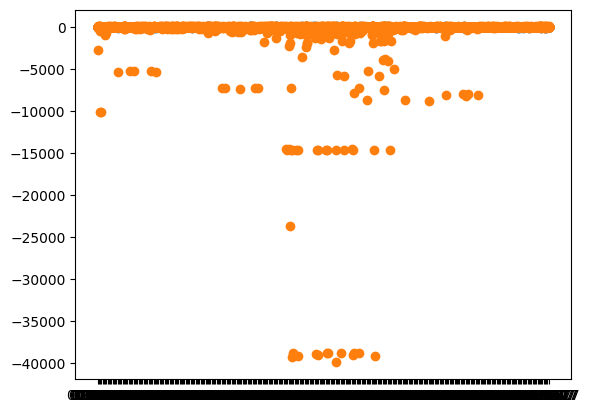

,date,airport_id,airport_name,temperature,wind_direction,wind_speed,snow_depth,cloud_status,visibility,latitude,longitude,elevation
65446,09-27-17,JFK,"JFK INTERNATIONAL AIRPORT, NY US",23.625,55.0,3.1,16.417626,9.0,13075.5,40.6386,-73.7622,3.4


In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# display(df_traffic)
# print(df_traffic.iloc[0]['date'])
# df_traffic = df_traffic[df_traffic['destination_airport'].isin(good_airports)]

traffic_viz = df_traffic.copy()
line_id = 'AA'
port_id = 'JFK'
date = '09-27-17'

# df of percent error of flight departure time (pos is early, neg is late)
error_depart_time = (df_traffic["actual_departure"].sub(df_traffic["scheduled_departure"]).div(df_traffic["scheduled_departure"]).mul(-100))
traffic_viz['error_depart_time'] = error_depart_time

# df of percent error of flight arrival time (pos is early, neg is late)
error_arrival_time = (df_traffic["actual_arrival"].sub(df_traffic["scheduled_arrival"]).div(df_traffic["scheduled_arrival"]).mul(-100))
traffic_viz['error_arrival_time'] = error_arrival_time

traffic_viz = traffic_viz.loc[traffic_viz['airline_id'] == line_id]
traffic_viz = traffic_viz.loc[traffic_viz['origin_airport'] == port_id]
display(traffic_viz)
# print(traffic_viz['airline_id'].unique())

# date against error in departure and arrival time
plt.scatter(traffic_viz['date'], traffic_viz['error_depart_time'])
plt.scatter(traffic_viz['date'], traffic_viz['error_arrival_time'])
plt.show()

##

weather_viz = df_weather.copy()

# weather for airport on a certain date
weather_viz = weather_viz.loc[weather_viz['airport_id'] == port_id].loc[weather_viz['date'] == date]
display(weather_viz)



In [13]:
df_depart = pd.DataFrame(columns=['Airline', 'Airport', 'Date', 'Early Departure', 'On-Time Departure', 'Late Departure'])
df_arrive = pd.DataFrame(columns=['Airline', 'Airport', 'Date', 'Early Arrival', 'On-Time Arrival', 'Late Arrival'])

traffic_viz = df_traffic.copy()

# df of percent error of flight departure time (pos is early, neg is late)
error_depart_time = (df_traffic["actual_departure"].sub(df_traffic["scheduled_departure"]).div(df_traffic["scheduled_departure"]).mul(-100))
traffic_viz['error_depart_time'] = error_depart_time

# df of percent error of flight arrival time (pos is early, neg is late)
error_arrival_time = (df_traffic["actual_arrival"].sub(df_traffic["scheduled_arrival"]).div(df_traffic["scheduled_arrival"]).mul(-100))
traffic_viz['error_arrival_time'] = error_arrival_time

for line_id in df_traffic['airline_id'].unique():
  for port_id in good_airports:

    traffic_viz = traffic_viz.loc[traffic_viz['airline_id'] == line_id].loc[traffic_viz['date'] == date]

    traffic_depart = traffic_viz.loc[traffic_viz['origin_airport'] == port_id]
    traffic_arrive = traffic_viz.loc[traffic_viz['destination_airport'] == port_id]

    app_depart = pd.DataFrame([[line_id, port_id, date, len(traffic_depart.loc[traffic_depart['error_depart_time'] > 0]), len(traffic_depart.loc[traffic_depart['error_depart_time'] == 0]), len(traffic_depart.loc[traffic_depart['error_depart_time'] < 0])]], columns=['Airline', 'Airport', 'Date', 'Early Departure', 'On-Time Departure', 'Late Departure'])
    app_arrive = pd.DataFrame([[line_id, port_id, date, len(traffic_arrive.loc[traffic_arrive['error_arrival_time'] > 0]), len(traffic_arrive.loc[traffic_arrive['error_arrival_time'] == 0]), len(traffic_arrive.loc[traffic_arrive['error_arrival_time'] < 0])]], columns=['Airline', 'Airport', 'Date', 'Early Arrival', 'On-Time Arrival', 'Late Arrival'])

    df_depart = pd.concat([df_depart, app_depart], ignore_index = True)
    df_arrive = pd.concat([df_arrive, app_arrive], ignore_index = True)

display(df_depart)
display(df_arrive)


,Airline,Airport,Date,Early Departure,On-Time Departure,Late Departure
0,AA,BQK,09-27-17,0,0,0
1,AA,MRY,09-27-17,0,0,0
2,AA,HYS,09-27-17,0,0,0
3,AA,OTZ,09-27-17,0,0,0
4,AA,HNL,09-27-17,6,0,0
...,...,...,...,...,...,...
1948,AS,LAS,09-27-17,0,0,0
1949,AS,ORF,09-27-17,0,0,0
1950,AS,JAN,09-27-17,0,0,0
1951,AS,RHI,09-27-17,0,0,0


,Airline,Airport,Date,Early Arrival,On-Time Arrival,Late Arrival
0,AA,BQK,09-27-17,0,0,0
1,AA,MRY,09-27-17,0,0,0
2,AA,HYS,09-27-17,0,0,0
3,AA,OTZ,09-27-17,0,0,0
4,AA,HNL,09-27-17,5,0,1
...,...,...,...,...,...,...
1948,AS,LAS,09-27-17,0,0,0
1949,AS,ORF,09-27-17,0,0,0
1950,AS,JAN,09-27-17,0,0,0
1951,AS,RHI,09-27-17,0,0,0


# Create Datasets

## Create node dictionary

Constant for all graphs and airlines. Use to convert airport ID to node number and node number to airport ID.

In [ ]:
# node dictionary
nodes_dict = {}
nodes_dict_bw = {}
ordered_good_airports = sorted(list(good_airports))

for i, airport_id in enumerate(ordered_good_airports):
    nodes_dict[i] = airport_id
    nodes_dict_bw[airport_id] = i
print(nodes_dict)
print(nodes_dict_bw)

{0: 'ABE', 1: 'ABQ', 2: 'ABR', 3: 'ABY', 4: 'ACK', 5: 'ACV', 6: 'ACY', 7: 'ADK', 8: 'AEX', 9: 'AKN', 10: 'AMA', 11: 'ANC', 12: 'APN', 13: 'ASE', 14: 'ATL', 15: 'AUS', 16: 'AVL', 17: 'AVP', 18: 'AZO', 19: 'BDL', 20: 'BET', 21: 'BGM', 22: 'BGR', 23: 'BHM', 24: 'BIS', 25: 'BJI', 26: 'BLI', 27: 'BNA', 28: 'BOI', 29: 'BOS', 30: 'BQK', 31: 'BQN', 32: 'BRD', 33: 'BRW', 34: 'BTR', 35: 'BUF', 36: 'BUR', 37: 'BWI', 38: 'CAE', 39: 'CAK', 40: 'CHA', 41: 'CHO', 42: 'CHS', 43: 'CIU', 44: 'CLE', 45: 'CLT', 46: 'CMH', 47: 'CMX', 48: 'COD', 49: 'COS', 50: 'COU', 51: 'CPR', 52: 'CRP', 53: 'CSG', 54: 'CVG', 55: 'CWA', 56: 'DAB', 57: 'DAL', 58: 'DAY', 59: 'DCA', 60: 'DEN', 61: 'DHN', 62: 'DLG', 63: 'DLH', 64: 'DSM', 65: 'DTW', 66: 'EAU', 67: 'ECP', 68: 'EGE', 69: 'EKO', 70: 'ELP', 71: 'ERI', 72: 'ESC', 73: 'EUG', 74: 'EVV', 75: 'EWR', 76: 'EYW', 77: 'FAI', 78: 'FAR', 79: 'FAT', 80: 'FAY', 81: 'FCA', 82: 'FLG', 83: 'FLL', 84: 'FNT', 85: 'FSM', 86: 'FWA', 87: 'GCC', 88: 'GEG', 89: 'GFK', 90: 'GJT', 91: 'GNV

## Create dataset directories for each airline

In [ ]:
airline_datasets_path = file_path + 'Raw-Datasets/'

for airline in airline_stock_list:
  if not os.path.exists(airline_datasets_path + airline):
    os.makedirs(airline_datasets_path + airline)

## Get all dates between 1/1/2017 and 12/31/2017

In [ ]:
from datetime import date

def daterange(start_date, end_date):
  for n in range(int((end_date - start_date).days)):
    yield start_date + timedelta(n)

start_date = date(2017, 1, 1)
end_date = date(2018, 1, 1)

dates = []

for single_date in daterange(start_date, end_date):
  dates.append(single_date.strftime("%m-%d-%y"))

print(dates)

['01-01-17', '01-02-17', '01-03-17', '01-04-17', '01-05-17', '01-06-17', '01-07-17', '01-08-17', '01-09-17', '01-10-17', '01-11-17', '01-12-17', '01-13-17', '01-14-17', '01-15-17', '01-16-17', '01-17-17', '01-18-17', '01-19-17', '01-20-17', '01-21-17', '01-22-17', '01-23-17', '01-24-17', '01-25-17', '01-26-17', '01-27-17', '01-28-17', '01-29-17', '01-30-17', '01-31-17', '02-01-17', '02-02-17', '02-03-17', '02-04-17', '02-05-17', '02-06-17', '02-07-17', '02-08-17', '02-09-17', '02-10-17', '02-11-17', '02-12-17', '02-13-17', '02-14-17', '02-15-17', '02-16-17', '02-17-17', '02-18-17', '02-19-17', '02-20-17', '02-21-17', '02-22-17', '02-23-17', '02-24-17', '02-25-17', '02-26-17', '02-27-17', '02-28-17', '03-01-17', '03-02-17', '03-03-17', '03-04-17', '03-05-17', '03-06-17', '03-07-17', '03-08-17', '03-09-17', '03-10-17', '03-11-17', '03-12-17', '03-13-17', '03-14-17', '03-15-17', '03-16-17', '03-17-17', '03-18-17', '03-19-17', '03-20-17', '03-21-17', '03-22-17', '03-23-17', '03-24-17', '03

For each airline, create 365 folders for graphs

In [ ]:
for airline in airline_stock_list:
  airline_datasets_path = file_path + 'Raw-Datasets/' + airline + "/"
  for date in dates:
    date_dir = airline_datasets_path + date + "/"
    if not os.path.exists(date_dir):
      os.makedirs(date_dir)

## Make node features, edge list, edge attr, and label for each graph

Function to calculate the time difference between two times stored as 4-digit integers, where the first two digits are the hour and the second two digits are the minutes.

In [ ]:
def get_min_diff(s, a):
  if math.isnan(a):
    return 1000
  s = int(s)
  a = int(a)
  sh = s // 100
  ah = a // 100
  sm = s - sh * 100
  am = a - ah * 100

  return (ah - sh) * 60 + am - sm

Funtion to calculate the average stock price of the airline from the given date to `window` days into the future, and calculate the change in price. If some day doesn't have a stock price (i.e. it's a weekend), just ignore it.

In [ ]:
import datetime
def get_stock_change(airline, d, window=5):
  stocks = [0 for i in range(window)]

  ds = d.split("-")
  mm = int(ds[0])
  dd = int(ds[1])
  yy = int(ds[2])

  start_date = datetime.date(yy + 2000, mm, dd)

  end_date = start_date + timedelta(days=window + 1)

  actual_days = 0 # number of days with stock data
  starting_stock = -1

  for single_date in daterange(start_date, end_date):
    row = df_stock[df_stock['date'] == single_date.strftime("%m-%d-%y")]

    x = row[airline].to_list()

    if (len(x) != 0): # if there is stock data
      if starting_stock == -1:
        starting_stock = x[0]
      stocks.append(x[0])
      actual_days += 1

  return ((sum(stocks) / actual_days) - starting_stock) / starting_stock * 100


In [ ]:
get_stock_change('AA', '01-01-17')

-0.053995680345569286

In [ ]:
num_nodes = len(good_airports)

for airline in airline_stock_list:
  if airline != 'AA':
    continue
  print("Saving airline " + airline + "...")
  airline_datasets_path = file_path + 'Raw-Datasets/' + airline + "/"
  df_traffic_airline = df_traffic[df_traffic['airline_id'] == airline]

  df_traffic_airline = df_traffic_airline.sort_values(['year', 'month', 'day'])

  for date in tqdm(dates):
    # print(date)
    date_dir = airline_datasets_path + date + "/"
    df_traffic_airline_date = df_traffic_airline[df_traffic_airline['date'] == date]

    node_degree = [0 for i in range(num_nodes)] # node features
    airport_delay_time = [0 for i in range(num_nodes)]
    edge_list = [[], []]
    edge_attr = []

    for index, row in df_traffic_airline_date.iterrows():
      ocode = nodes_dict_bw[row['origin_airport']]
      dcode = nodes_dict_bw[row['destination_airport']]

      node_degree[ocode] += 1
      node_degree[dcode] += 1

      edge_list[0].append(ocode)
      edge_list[1].append(dcode)

      sdep = row['scheduled_departure']
      adep = row['actual_departure']

      delay = get_min_diff(sdep, adep)

      if delay > 0:
        airport_delay_time[ocode] += delay

      edge_attr.append(delay)

    ##### node features: x #####
    node_features = [node_degree, airport_delay_time]
    node_features = torch.tensor(node_features)
    node_features.resize_(num_nodes, 2) # num_nodes, num_node_features

    # print(node_features.shape)

    node_path = date_dir + "x.pt"
    torch.save(node_features, node_path)

    ##### edge list: edge list #####
    edge_list = torch.tensor(edge_list)
    # print(edge_list.shape)
    num_edges = edge_list.shape[1]

    edge_list_path = date_dir + "edge_list.pt"
    torch.save(edge_list, edge_list_path)

    ##### edge attr: edge attr #####
    edge_attr = torch.tensor(edge_attr)
    edge_attr.resize_(num_edges, 1) # num_edges, num_edge_features
    # print(edge_attr.shape)

    edge_attr_path = date_dir + "edge_attr.pt"
    torch.save(edge_attr, edge_attr_path)

    ##### label: y #####
    label = get_stock_change(airline, date, window=7)
    label = torch.tensor(label)
    label.resize_(1, 1)

    label_path = date_dir + "y.pt"
    torch.save(label, label_path)


  print("Done with " + airline)



Saving airline AA...


100%|██████████| 365/365 [00:47<00:00,  7.65it/s]

Done with AA


In [ ]:
node_feat = torch.load('/content/drive/MyDrive/Summer_Invitational_2023_Datathon_Datasets/Raw-Datasets/AA/01-02-17/x.pt')
for i,r in enumerate(node_feat):
  print(nodes_dict[i], r)

ABE tensor([0, 0])
ABQ tensor([0, 0])
ABR tensor([0, 0])
ABY tensor([0, 0])
ACK tensor([0, 0])
ACV tensor([0, 0])
ACY tensor([0, 0])
ADK tensor([45, 20])
AEX tensor([0, 0])
AKN tensor([ 0, 19])
AMA tensor([0, 0])
ANC tensor([0, 0])
APN tensor([0, 0])
ASE tensor([ 0, 14])
ATL tensor([ 6, 60])
AUS tensor([0, 0])
AVL tensor([0, 0])
AVP tensor([0, 8])
AZO tensor([ 0, 22])
BDL tensor([0, 0])
BET tensor([0, 0])
BGM tensor([2, 0])
BGR tensor([  8, 457])
BHM tensor([6, 0])
BIS tensor([0, 0])
BJI tensor([0, 0])
BLI tensor([0, 0])
BNA tensor([0, 0])
BOI tensor([0, 0])
BOS tensor([ 0, 76])
BQK tensor([28,  0])
BQN tensor([0, 0])
BRD tensor([ 4, 20])
BRW tensor([0, 0])
BTR tensor([4, 0])
BUF tensor([0, 0])
BUR tensor([0, 0])
BWI tensor([ 0, 27])
CAE tensor([0, 0])
CAK tensor([0, 0])
CHA tensor([0, 0])
CHO tensor([ 0, 35])
CHS tensor([0, 0])
CIU tensor([0, 0])
CLE tensor([4, 0])
CLT tensor([0, 0])
CMH tensor([0, 0])
CMX tensor([0, 0])
COD tensor([0, 0])
COS tensor([0, 0])
COU tensor([0, 0])
CPR ten

# Code from before: use if we want to use more edge attributes/features

In [ ]:
from collections import defaultdict

edges_dict = defaultdict(list)

for _, row in df_andy.iterrows():
    origin_date = row['date']
    destination_date = row['date']
    origin_airport_id = row['origin_airport']
    destination_airport_id = row['destination_airport']
    if origin_airport_id not in wrong_airports and destination_airport_id not in wrong_airports:
        origin_key = nodes_dict.get(f"{origin_airport_id}_{origin_date}")
        destination_key = nodes_dict.get(f"{destination_airport_id}_{destination_date}")
        if origin_key is not None and destination_key is not None:
            edges_dict[origin_key].append(destination_key)

edges_array = [[origin_key, dest_key] for origin_key, dest_list in edges_dict.items() for dest_key in dest_list]
print(edges_array)

In [ ]:
#edge features
df_edge_features = df_andy.copy()
df_edge_features['flight_duration'] = (df_edge_features['actual_arrival'] - df_edge_features['actual_departure']).astype('timedelta64[m]')
df_edge_features['arrival_delay'] = (df_edge_features['actual_arrival'] - df_edge_features['scheduled_arrival']).astype('timedelta64[m]')
df_edge_features['departure_delay'] = (df_edge_features['actual_departure'] - df_edge_features['scheduled_departure']).astype('timedelta64[m]')

df_edge_features = df_edge_features.merge(df_stock, left_on='date', right_on='date', how='left')

def get_airport_details(airport_id, date):
    airport_row = df_airports[(df_airports['airport_id'] == airport_id)]
    latitude = airport_row['latitude'].values[0]
    longitude = airport_row['longitude'].values[0]
    return latitude, longitude

def get_weather_details(airport_id, date):
    weather_row = df_weather[(df_weather['date'] == date) & (df_weather['airport_id'] == airport_id)]
    temperature = weather_row['temperature'].values[0]
    visibility = weather_row['visibility'].values[0]
    wind_direction = weather_row['wind_direction'].values[0]
    wind_speed = weather_row['wind_speed'].values[0]
    snow_depth = weather_row['snow_depth'].values[0]
    cloud_status = weather_row['cloud_status'].values[0]
    return temperature, visibility, wind_direction, wind_speed, snow_depth, cloud_status

#calcualte distance between airports using haversine formula
def calculate_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

airline_ids = []
stock_prices = []
flight_durations = []
arrival_delays = []
departure_delays = []
origin_temperatures = []
origin_visibilities = []
origin_wind_directions = []
origin_wind_speeds = []
origin_snow_depths = []
origin_cloud_statuses = []
destination_temperatures = []
destination_visibilities = []
destination_wind_directions = []
destination_wind_speeds = []
destination_snow_depths = []
destination_cloud_statuses = []
distances = []

for edge in edges_array:
    origin_key, destination_key = edge
    origin_airport_id, origin_date = nodes_dict[origin_key].split('_')
    destination_airport_id, destination_date = nodes_dict[destination_key].split('_')

    row = df_andy[(df_andy['origin_airport'] == origin_airport_id) &
                     (df_andy['destination_airport'] == destination_airport_id) &
                     (df_andy['date'] == origin_date)]
    airline_id = row['airline_id'].values[0]

    stock_price = df_edge_features[df_edge_features['date'] == origin_date][airline_id].values[0]

    origin_latitude, origin_longitude = get_airport_details(origin_airport_id, origin_date)
    origin_temperature, origin_visibility, origin_wind_direction, origin_wind_speed, origin_snow_depth, origin_cloud_status = get_weather_details(origin_airport_id, origin_date)

    destination_latitude, destination_longitude = get_airport_details(destination_airport_id, destination_date)
    distance = calculate_distance(origin_longitude, origin_latitude, destination_longitude, destination_latitude)
    destination_temperature, destination_visibility, destination_wind_direction, destination_wind_speed, destination_snow_depth, destination_cloud_status = get_weather_details(destination_airport_id, destination_date)

    airline_ids.append(airline_id)
    stock_prices.append(stock_price)
    flight_durations.append(row['flight_duration'].values[0])
    arrival_delays.append(row['arrival_delay'].values[0])
    departure_delays.append(row['departure_delay'].values[0])
    origin_temperatures.append(origin_temperature)
    origin_visibilities.append(origin_visibility)
    origin_wind_directions.append(origin_wind_direction)
    origin_wind_speeds.append(origin_wind_speed)
    origin_snow_depths.append(origin_snow_depth)
    origin_cloud_statuses.append(origin_cloud_status)
    destination_temperatures.append(destination_temperature)
    destination_visibilities.append(destination_visibility)
    destination_wind_directions.append(destination_wind_direction)
    destination_wind_speeds.append(destination_wind_speed)
    destination_snow_depths.append(destination_snow_depth)
    destination_cloud_statuses.append(destination_cloud_status)
    distances.append(distance)

edge_features_df = pd.DataFrame({
    'airline_id': airline_ids,
    'stock_price': stock_prices,
    'flight_duration': flight_durations,
    'arrival_delay': arrival_delays,
    'departure_delay': departure_delays,
    'origin_temperature': origin_temperatures,
    'origin_visibility': origin_visibilities,
    'origin_wind_direction': origin_wind_directions,
    'origin_wind_speed': origin_wind_speeds,
    'origin_snow_depth': origin_snow_depths,
    'origin_cloud_status': origin_cloud_statuses,
    'destination_temperature': destination_temperatures,
    'destination_visibility': destination_visibilities,
    'destination_wind_direction': destination_wind_directions,
    'destination_wind_speed': destination_wind_speeds,
    'destination_snow_depth': destination_snow_depths,
    'destination_cloud_status': destination_cloud_statuses,
    'distance': distances
})

edge_features_df.head()

In [ ]:
#edge list
edges_dict = {}
#df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%m/%d/%y')
for _, row in df_andy.iterrows():
    origin_date = row['date']
    destination_date = row['date']
    origin_airport_id = row['origin_airport']
    destination_airport_id = row['destination_airport']
    if origin_airport_id not in wrong_airports and destination_airport_id not in wrong_airports:
        origin_key = [k for k, v in nodes_dict.items() if v == f"{origin_airport_id}_{origin_date}"][0]
        print(origin_key)
        destination_key = [k for k, v in nodes_dict.items() if v == f"{destination_airport_id}_{destination_date}"][0]
        if origin_key in edges_dict:
            edges_dict[origin_key].append(destination_key)
        else:
            edges_dict[origin_key] = [destination_key]
        #print(edges_dict)

edges_array = [[origin_key, dest_key] for origin_key, dest_list in edges_dict.items() for dest_key in dest_list]
#print(edges_array)

In [ ]:
#stock price change
df_stock['date'] = pd.to_datetime(df_stock['date'])
def calculate_average(stock_prices):
    return stock_prices.shift(-1).rolling(window=5).mean()

for airline in df_stock.columns[1:]:
    next_avg = calculate_average(df_stock[airline])
    df_stock[f'{airline}_price_change'] = df_stock[airline] - next_avg
print(df_stock)